# SV-RCNet

In [118]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader, random_split, SequentialSampler, BatchSampler
from torchvision import models, transforms
from torch import nn, optim

from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils.clean_labels import clean_labels
from utils.build_dataset import SVRCDataset

import os
from datetime import datetime
import random
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preprocessing

### Extract frames

In [2]:
# put videos here!
video_base = 'data/videos'
videos = os.listdir(video_base)
# images will be output to here
image_base = 'data/images'
if not os.path.exists(image_base):
    os.mkdir(image_base)

In [3]:
# command line: 
# ffmpeg -i {input_video} -r {frame_rate} [-f {force_format} (not needed)] {output_images}
# doc: https://ffmpeg.org/ffmpeg.html
for video in videos:
    input_path = os.path.join(video_base, video)
    # make dirs
    output_base = image_base + '/{}'.format(video.split('.')[0])
    if not os.path.exists(output_base):
        os.mkdir(output_base)
    output_path = os.path.join(output_base, '%d.png')
    # command
    print('Frames extracted from {} to {}'.format(input_path, output_path))
    #!ffmpeg -i {input_path} -r 1 {output_path}

Frames extracted from data/videos/RALIHR_surgeon01_fps01_0008.mp4 to data/images/RALIHR_surgeon01_fps01_0008/%d.png
ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125573833/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125573833/_build_env/bin/pkg-config --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin2

frame= 4568 fps=181 q=-0.0 Lsize=N/A time=01:16:08.00 bitrate=N/A speed= 181x    
video:2352964kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
Frames extracted from data/videos/RALIHR_surgeon01_fps01_0004.mp4 to data/images/RALIHR_surgeon01_fps01_0004/%d.png
ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125573833/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame -

[swscaler @ 0x1409a8000] No accelerated colorspace conversion found from yuv420p to rgb24.
Output #0, image2, to 'data/images/RALIHR_surgeon01_fps01_0007/%d.png':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.45.100
    Stream #0:0(eng): Video: png, rgb24, 854x480 [SAR 1280:1281 DAR 16:9], q=2-31, 200 kb/s, 1 fps, 1 tbn, 1 tbc (default)
    Metadata:
      handler_name    : VideoHandler
      encoder         : Lavc58.91.100 png
frame=  608 fps=178 q=-0.0 Lsize=N/A time=00:10:08.00 bitrate=N/A speed= 178x    
video:298651kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
Frames extracted from data/videos/RALIHR_surgeon01_fps01_0006.mp4 to data/images/RALIHR_surgeon01_fps01_0006/%d.png
ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125573833

[swscaler @ 0x1401a8000] No accelerated colorspace conversion found from yuv420p to rgb24.
Output #0, image2, to 'data/images/RALIHR_surgeon01_fps01_0003/%d.png':
  Metadata:
    major_brand     : isom
    minor_version   : 512
    compatible_brands: isomiso2avc1mp41
    encoder         : Lavf58.45.100
    Stream #0:0(eng): Video: png, rgb24, 854x480 [SAR 1280:1281 DAR 16:9], q=2-31, 200 kb/s, 1 fps, 1 tbn, 1 tbc (default)
    Metadata:
      handler_name    : VideoHandler
      encoder         : Lavc58.91.100 png
frame= 1540 fps=170 q=-0.0 Lsize=N/A time=00:25:40.00 bitrate=N/A speed= 170x    
video:817936kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: unknown
Frames extracted from data/videos/RALIHR_surgeon01_fps01_0001.mp4 to data/images/RALIHR_surgeon01_fps01_0001/%d.png
ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125573833

### Extract labels

In [4]:
# clean

In [5]:
# some useless rows are manually deleted
labels_path = 'data/labels/phase_trainingData_clean.csv'
names_path = 'data/labels/names.csv'
# this is already a cleaned file
labels_df = pd.read_csv(labels_path)
names_df = pd.read_csv(names_path, names=['Name'])

# convert time string to int
# start time
t0 = datetime(1900, 1, 1)
def time2int(t):
    # if convertable
    return (
        # time given in MM:SS
        datetime.strptime(t, '%M:%S') - t0
    ).seconds if len(t.split(':')) == 2 else (
        # time given in HH:MM:SS
        datetime.strptime(t, '%H:%M:%S') - t0
    ).seconds

# extract names
for video in videos[:2]:
    images = os.listdir(os.path.join(image_base, video.split('.')[0]))
    # get df corresponding to current video
    video_df = labels_df.loc[labels_df['videoName'] == video.split('.')[0]]
    # add two columns
    video_df[['StartSec', 'EndSec']] = video_df[['Start', 'End']].applymap(time2int)
    # 这warning好烦但我懒得改了
    for image in images:
        # check paths
        base = os.path.join(image_base, video.split('.')[0])
        path = os.path.join(base, image)
        # avoid renaming twice
        assert '-' not in path, 'Incorrect format to be renamed: {}'.format(path)
        # if '-' in image:
        #     continue
        t = int(image.split('.')[0])
        # select interval and remove tailing digits
        name = video_df[
            (video_df['StartSec'] <= t) & (t <= video_df['EndSec'])
        ]['PhaseNameClean'].iloc[0]
        # find correct integer labels
        label = names_df[names_df['Name'] == name].index[0]
        # incorperate label into filenames
        new_path = ''.join(path.split('.')[:-1]) + '-{}.'.format(label) + path.split('.')[-1]
        # rename all files
        os.rename(path, new_path)

/var/folders/gx/99tz19ls4_j6wcgb46p_shjh0000gn/T/ipykernel_26878/3843760164.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_df[['StartSec', 'EndSec']] = video_df[['Start', 'End']].applymap(time2int)
/var/folders/gx/99tz19ls4_j6wcgb46p_shjh0000gn/T/ipykernel_26878/3843760164.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_df[['StartSec', 'EndSec']] = video_df[['Start', 'End']].applymap(time2int)
/var/folders/gx/99tz19ls4_j6wcgb46p_shjh0000gn/T/ipykernel_26878/3843760164.py:27: SettingWi

## Dataset Construction

In [ ]:
# Data properties
num_labels = 17

In [6]:
# get all images and labels
image_paths = []
labels = []

for video in videos[:2]:
    base = os.path.join(image_base, video.split('.')[0])
    image_paths += list(map(
        lambda img: os.path.join(base, img), 
        os.listdir(base)
    ))
    labels += list(map(
        lambda img: int(img.split('.')[0].split('-')[1]), 
        os.listdir(base)
    ))

list(zip(image_paths, labels))

[('data/images/RALIHR_surgeon01_fps01_0008/13-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/2402-1.png', 1),
 ('data/images/RALIHR_surgeon01_fps01_0008/818-11.png', 11),
 ('data/images/RALIHR_surgeon01_fps01_0008/48-10.png', 10),
 ('data/images/RALIHR_surgeon01_fps01_0008/2194-6.png', 6),
 ('data/images/RALIHR_surgeon01_fps01_0008/1014-11.png', 11),
 ('data/images/RALIHR_surgeon01_fps01_0008/918-11.png', 11),
 ('data/images/RALIHR_surgeon01_fps01_0008/1425-13.png', 13),
 ('data/images/RALIHR_surgeon01_fps01_0008/1374-13.png', 13),
 ('data/images/RALIHR_surgeon01_fps01_0008/2268-6.png', 6),
 ('data/images/RALIHR_surgeon01_fps01_0008/1918-6.png', 6),
 ('data/images/RALIHR_surgeon01_fps01_0008/2081-16.png', 16),
 ('data/images/RALIHR_surgeon01_fps01_0008/1525-13.png', 13),
 ('data/images/RALIHR_surgeon01_fps01_0008/1274-13.png', 13),
 ('data/images/RALIHR_surgeon01_fps01_0008/592-10.png', 10),
 ('data/images/RALIHR_surgeon01_fps01_0008/1556-16.png', 16),
 ('data/images/RALIHR_s

In [7]:
# define transforms
data_transform = {
    "train": transforms.Compose([
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
}

In [8]:
# get training set
train_set = SVRCDataset(
    image_paths, 
    labels, 
    data_transform['train']
)

In [9]:
# get dataloader
train_loader = DataLoader(train_set, batch_size = 8, shuffle = True, num_workers = 0)

In [10]:
X, y = next(iter(train_loader))
X, y

(tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-

## Data Visualization

In [11]:
# fishnet曹老师的代码
def plot(x,y):
    """
    Plot random images for verification
    """

    fig = plt.figure(figsize=(16,8))
    plt.subplots_adjust(top=1.2)
    col = 4
    row = 2
    print(str(col*row)+" Random images and their labels")
    ri = random.sample(range(0,len(x)),col*row)
    rii = 0
    for i in range(1, col*row+1):
        img = np.copy(x[ri[rii]])
        img = np.asarray(img, dtype=np.float32)
        fig.add_subplot(row,col,i)
        x_label = 'Label : ' + str(y[ri[rii]])
        plt.xlabel(x_label)
        img = img/np.amax(img)
        img = np.clip(img, 0, 1)
        # shift for pytorch
        plt.imshow(np.moveaxis(img, 0, -1), interpolation = 'nearest')
        rii = rii + 1
    _ = plt.show()

8 Random images and their labels


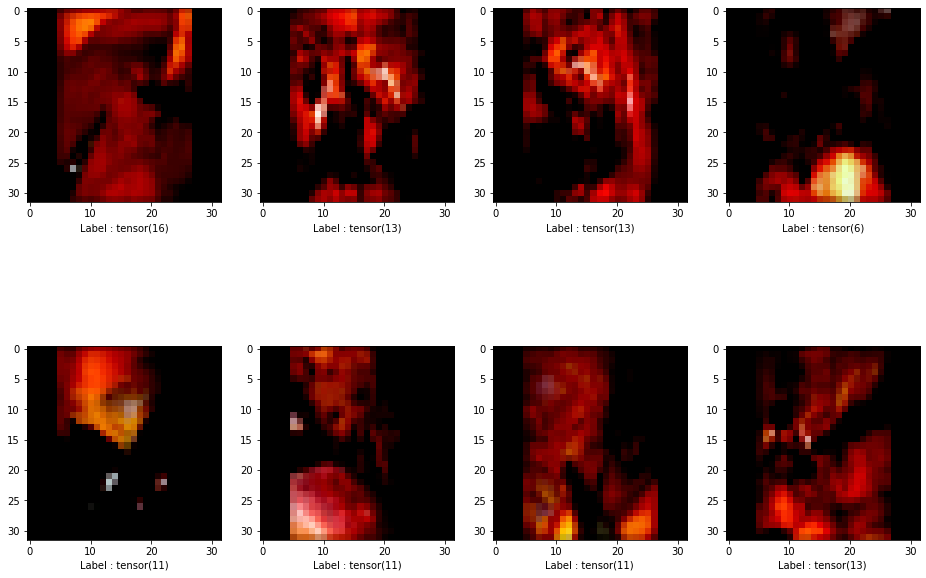

In [12]:
plot(X, y)

## class SVRCDataset

In [57]:
class SVRCDataset(Dataset):
    def __init__(self, image_path: list, image_class: list, transform = None):
        self.image_path = image_path
        self.image_class = image_class
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, item): #can add more rules to pick data
        img = Image.open(self.image_path[item])
        label = self.image_class[item]
        if self.transform is not None:
            img = self.transform(img)

        return {'feature': img, 'label': label}

class MyDataset(Dataset):
    def __init__(self, labels, features):
        super(MyDataset, self).__init__()
        self.labels = labels
        self.features = features
    
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx: int):
        feature = self.features[idx]
        label = self.labels[idx]
        return {'feature': feature, 'label': label}

## class Train

In [23]:
# Training parameters
LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

class Train(object):
    def __init__(self, model) -> None:
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.criterion = nn.CrossEntropyLoss()
        self.shuffle = True
    
    def train(self, labels, features, transform):
        self.model.train()
        dataset = SVRCDataset(features, labels, transform)
        loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = self.shuffle)
        for epoch in range(EPOCHS):
            train_loss = 0.0
            train_acc = 0
            for i, data in enumerate(loader):
                features  = data['feature'].float()
                labels = data['label']

                self.optimizer.zero_grad()
                predictions = self.model(features)
                loss = self.criterion(predictions, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                preds = torch.max(predictions.data, 1)[1]
                train_acc += (preds==labels).sum().item()

            train_loss /= len(dataset)
            train_acc /= len(dataset)
            if epoch==0 or (epoch+1)%1==0:
                print('Epoch[{}/{}] loss:{:.3} | acc:{:.4}'.format(epoch+1, EPOCHS, train_loss, train_acc))

In [16]:
dataset = SVRCDataset(image_paths, labels, data_transform['train'])
loader = DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
next(iter(loader))

{'feature': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
  

In [17]:
print(len(set(labels)))

11


## class CNN

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,6,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6,16,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc1 = nn.Sequential(nn.Linear(16*8*8, 512), nn.ReLU(),)
        self.fc2 = nn.Sequential(nn.Linear(512, 128), nn.ReLU(),)
        self.out = nn.Linear(128,num_labels)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

    def predict(self, features):
        self.eval()
        features = torch.from_numpy(features).float()
        labels = self.forward(features).detach().numpy()
        labels = np.argmax(labels, axis=1)
        return labels

## CNN results

In [24]:
# Weights path
WeightsPath = './models/weights'

# Data Preprocessing

#N,C,H,W = 10, 3, 224, 224
#X = np.zeros((N,C,H,W))
#y = np.zeros((N,))
X = image_paths
y = labels
#model = ResNet()
model = CNN()
print(model)
start_time = time.time()

trainer = Train(model)
trainer.train(y, X, data_transform['train'])

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

torch.save(model.state_dict(),WeightsPath)

#model = SVRC()
#model.load_state_dict(torch.load(WeightsPath))

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=128, out_features=17, bias=True)
)
Epoch[1/10] loss:0.0262 | acc:0.4186
Epoch[2/10] loss:0.0162 | acc:0.6434
Epoch[3/10] loss:0.0121 | acc:0.7409
Epoch[4/10] loss:0.0086 | acc:0.8266
Epoch[5/10] loss:0.00726 | acc:0.8465
Epoch[6/10] loss:0.00563 | acc:0.8781
Epoch[7/10] loss:0.00473 | acc:0.8922
Epoch[8/10] loss:0.004 | acc:0.9143
Epoch[9/10] loss:0.00329 |

## resnet18 results

In [26]:
# Data
X = image_paths
y = labels
model = models.resnet18()
model.fc = nn.Linear(512,num_labels)
print(model)
start_time = time.time()

trainer = Train(model)
trainer.train(y, X, data_transform['train'])

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
len(dataset)

4470

## Validation

In [58]:
# train-val
train = SVRCDataset(image_paths[:4000], labels[:4000], data_transform['train'])
test = SVRCDataset(image_paths[4000:], labels[4000:], data_transform['train'])
train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)
#next(iter(train_loader))

In [60]:
next(iter(train_loader))

{'feature': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
  

## class TrainVal

In [70]:
# Training parameters
LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10

class TrainVal(object):
    def __init__(self, model) -> None:
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.criterion = nn.CrossEntropyLoss()
        self.shuffle = True

    def train(self, labels, features, transform):
        self.model.train()
        dataset = SVRCDataset(image_paths, labels, transform)
        train, test = random_split(dataset, [4000,470])
        train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = self.shuffle)
        test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = self.shuffle)
        for epoch in range(EPOCHS):
            train_loss = 0.0
            train_acc = 0.0
            for i, data in enumerate(train_loader):
                features  = data['feature'].float()
                labels = data['label']

                self.optimizer.zero_grad()
                predictions = self.model(features)
                loss = self.criterion(predictions, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                preds = torch.max(predictions.data, 1)[1]
                train_acc += (preds==labels).sum().item()

            train_loss /= len(train)
            train_acc /= len(train)

            valid_loss = 0.0
            valid_acc = 0.0
            total = 0
            self.model.eval()
            for i, data in enumerate(test_loader):
                features = data['feature']
                labels = data['label']
                
                predictions = self.model(features)
                loss = self.criterion(predictions,labels)
                valid_loss += loss.item()
                
                preds = torch.max(predictions.data, 1)[1]
                valid_acc += (preds==labels).sum().item()
                total += features.size(0)
            
            valid_loss /= len(test)
            valid_acc /= len(test)
            
            print(
                f'Epoch {epoch+1} Training Loss: {train_loss} Validation Loss: {valid_loss} || '
                f'Train_acc: {train_acc} Valid_acc: {valid_acc}'
            )    

## Validation results

In [71]:
# Data
X = image_paths
y = labels
# Model
model = models.resnet18()
model.fc = nn.Linear(512,num_labels)
print(model)

start_time = time.time()

trainer = TrainVal(model)
trainer.train(y, X, data_transform['train'])

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Pretrain
### Pretarin the resnet18 (pretrained on imagenet) on our datset.

In [ ]:
# Weights path
WeightsPath = './models/weights'

# Data
X = image_paths
y = labels
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512,num_labels)
trainer = Train(model)
trainer.train(y, X, data_transform['train'])

torch.save(model.state_dict(),WeightsPath)

## class SVRCNet

In [73]:
# Training parameters
LR = 1e-3
BATCH_SIZE = 30
EPOCHS = 10

In [207]:
class SVRC(nn.Module):
    def __init__(self):
        super(SVRC,self).__init__()
        # ResNet-18
        self.resnet18 = nn.Sequential(*(
            list(
                models.resnet18(pretrained=True).children()
            )[:-1]
        ))
        #self.resnet18.eval()
        self.pretrain = True
        # LSTM
        self.lstm = nn.LSTM(512,512)
        self.full = nn.Linear(512,num_labels)
        
    def forward(self,x):
        x = self.resnet18(x)
        # Reshape
        #print(x.shape)
        if not self.pretrain:
            x = x.view(3,10,-1) # time step, batch size
            x,_ = self.lstm(x)
        x = x.view(-1,512)
        x = self.full(x)
        return x if self.pretrain else nn.Softmax(1)(x).view(30,-1)

## Load weights and train SVRCNet

In [125]:
class SVRCDataset(Dataset):
    def __init__(self, image_path: list, image_class: list, transform = None):
        self.image_path = image_path
        self.image_class = image_class
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, item): #can add more rules to pick data
        img = Image.open(self.image_path[item])
        label = self.image_class[item]
        if self.transform is not None:
            img = self.transform(img)

        return {'feature': img, 'label': label}

In [126]:
def sort_images(x):
    vid = int(x[0].split('_')[-1].split('/')[0])
    frame = int(x[0].split('/')[-1].split('-')[0])
    return vid*7200 + frame

In [127]:
image_paths_lstm = []
labels_lstm = []
for path,label in sorted(zip(image_paths, labels), key=sort_images):
    image_paths_lstm.append(path)
    labels_lstm.append(label)

In [128]:
sorted(zip(image_paths, labels), key=sort_images)

[('data/images/RALIHR_surgeon01_fps01_0008/1-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/2-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/3-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/4-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/5-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/6-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/7-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/8-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/9-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/10-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/11-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/12-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/13-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/14-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/15-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/16-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0008/17-14.

In [137]:
# LSTM
train = SVRCDataset(image_paths_lstm[:4000], labels_lstm[:4000], data_transform['train'])
test = SVRCDataset(image_paths_lstm[4000:], labels_lstm[4000:], data_transform['train'])
train_loader = DataLoader(
    train, 
    batch_sampler=BatchSampler(SequentialSampler(train), BATCH_SIZE, drop_last=True), 
    shuffle = False
)
test_loader = DataLoader(
    test, 
    batch_sampler=BatchSampler(SequentialSampler(test), BATCH_SIZE, drop_last=True), 
    shuffle = False
)
#next(iter(train_loader))

In [138]:
train_loader

In [139]:
for i,b in enumerate(test_loader):
    print(b)
    break

{'feature': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179

In [209]:
# Training parameters LSTM
LR = 1e-3
BATCH_SIZE = 30
EPOCHS = 5

class TrainVal(object):
    def __init__(self, model) -> None:
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.criterion = nn.CrossEntropyLoss()

    def train(self, labels, features, transform):
        if self.model.pretrain:
            self.model.train()
            train = SVRCDataset(image_paths[:4000], labels[:4000], transform)
            test = SVRCDataset(image_paths[4000:], labels[4000:], transform)
            train_loader = DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
            test_loader = DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

        else:
            self.model.resnet18.eval()
            self.model.lstm.train()
            self.model.full.train()

            train = SVRCDataset(image_paths_lstm[:4000], labels_lstm[:4000], transform)
            test = SVRCDataset(image_paths_lstm[4000:], labels_lstm[4000:], transform)
            train_loader = DataLoader(
                train, 
                batch_sampler=BatchSampler(SequentialSampler(train), BATCH_SIZE, drop_last=True), 
                shuffle = False
            )
            test_loader = DataLoader(
                test, 
                batch_sampler=BatchSampler(SequentialSampler(test), BATCH_SIZE, drop_last=True), 
                shuffle = False
            )
            print(self.model.pretrain)

        for epoch in range(EPOCHS):
            train_loss = 0.0
            train_acc = 0.0
            for i, data in enumerate(train_loader):
                features  = data['feature'].float()
                labels = data['label']

                self.optimizer.zero_grad()
                predictions = self.model(features)
                loss = self.criterion(predictions, labels)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                preds = torch.max(predictions.data, 1)[1]
                train_acc += (preds==labels).sum().item()

            train_loss /= len(train)
            train_acc /= len(train)

            valid_loss = 0.0
            valid_acc = 0.0
            total = 0
            self.model.eval()
            for i, data in enumerate(test_loader):
                features = data['feature']
                labels = data['label']
                
                predictions = self.model(features)
                loss = self.criterion(predictions,labels)
                valid_loss += loss.item()
                
                preds = torch.max(predictions.data, 1)[1]
                print(preds)
                valid_acc += (preds==labels).sum().item()
                total += features.size(0)

            valid_loss /= len(test)
            valid_acc /= len(test)

            print(
                f'Epoch {epoch+1} Training Loss: {train_loss} Validation Loss: {valid_loss} || '
                f'Train_acc: {train_acc} Valid_acc: {valid_acc}'
            )    

In [189]:
WeightsPath = './models/weights'

# Data
X = image_paths
y = labels

# resnet18 Model
model = SVRC()
print(model)

start_time = time.time()

trainer = TrainVal(model)
trainer.train(y, X, data_transform['train'])
torch.save(model.state_dict(),WeightsPath)

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

SVRC(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [210]:
# SVRC Model
model = SVRC()
print(model)

model.pretrain = False
model.load_state_dict(torch.load(WeightsPath))

start_time = time.time()

trainer = TrainVal(model)
trainer.train(y, X, data_transform['train'])

end_time = time.time()
print('Time:{:.2}min'.format((end_time-start_time)/60.0))

SVRC(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

KeyboardInterrupt: 